In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime 
import seaborn as sns
%matplotlib inline

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import explained_variance_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.linear_model import LassoCV
from sklearn.linear_model import RidgeCV
from sklearn.utils import shuffle
import statsmodels.api as sm

/anaconda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [7]:
def set_data(file):
    bikeshare_machine = pd.read_csv(file, 
                        parse_dates=['Start date', 'End date', 'start_date_short', 'end_date_short'])
    bikeshare_machine.drop('Unnamed: 0', 1, inplace=True)
    included_cols = ['start_station','end_station','Member Type','time_diff','season','mnth','holiday',
                     'weekday','workingday','weathersit','temp','hum','windspeed','miles']
    bikeshare_machine = bikeshare_machine[included_cols]
    bikeshare_machine['season'] = bikeshare_machine['season'].astype('category')
    bikeshare_machine['mnth'] = bikeshare_machine['mnth'].astype('category')
    bikeshare_machine['holiday'] = bikeshare_machine['holiday'].astype('category')
    bikeshare_machine['weekday'] = bikeshare_machine['weekday'].astype('category')
    bikeshare_machine['workingday'] = bikeshare_machine['workingday'].astype('category')
    bikeshare_machine['weathersit'] = bikeshare_machine['weathersit'].astype('category')
    bikeshare_machine['Member Type'] = bikeshare_machine['Member Type'].astype('category')
    bikeshare_machine['start_station'] = bikeshare_machine['start_station'].astype('category')
    bikeshare_machine['end_station'] = bikeshare_machine['end_station'].astype('category')
    col_names = ['start_station', 'end_station','member_type','time_diff','season','month','holiday',
             'weekday','work_day','weather_cat','temperature','humidity','windspeed','miles']
    bikeshare_machine.columns = col_names
    tmin = -8
    tmax = 39
    hum_max = 100
    wind_max = 67
    bikeshare_machine['temp'] = bikeshare_machine['temperature'] * (tmax - tmin) + tmin
    bikeshare_machine['hum'] = bikeshare_machine['humidity'] * 100
    bikeshare_machine['wind'] = bikeshare_machine['windspeed'] * 67
    bikeshare_machine.drop(['temperature', 'humidity', 'windspeed'], 1)
    bikeshare_machine = pd.get_dummies(bikeshare_machine, 
                                 columns=['member_type','holiday','work_day'], drop_first=True)
    bikeshare_machine = pd.get_dummies(bikeshare_machine, 
                                 columns=['start_station','end_station','season','month','weekday','weather_cat'])
    bikeshare_machine = shuffle(bikeshare_machine)
    return bikeshare_machine

In [8]:
file = '/Users/matthewcassi/Documents/Bike-Sharing-Dataset/less_bikeshare_lat_lon.csv'
bikeshare_machine = set_data(file)

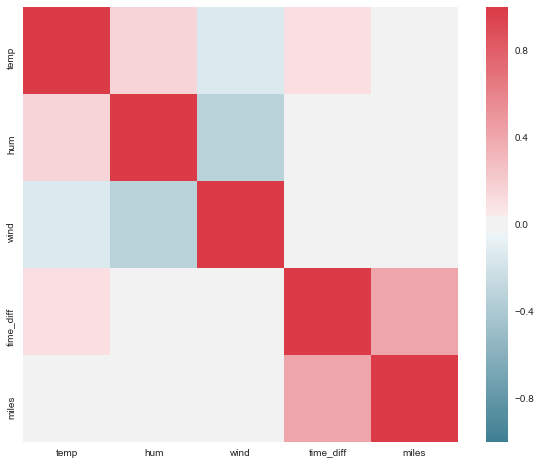

In [10]:
# Checking the correlations between continuous variables
corr = bikeshare_machine[['temp', 'hum', 'wind', 'time_diff', 'miles']].corr()
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

### Model 1 - Remove Some Variables that are correlated

In [13]:
# Leave workday, drop weekdays, leave season, drop month
# Workday overlaps with workday/not workday and months overlap with seasons
remove_cols = ['weekday_0', 'weekday_1','weekday_2','weekday_3','weekday_4','weekday_5','weekday_6', 
              'month_1','month_2','month_3','month_4','month_5','month_6','month_7','month_8','month_9',
              'month_10','month_11','month_12','temperature','humidity','windspeed', 'time_diff']
X1 = np.matrix(bikeshare_machine.drop(remove_cols, 1))
y1 = bikeshare_machine['time_diff']

In [14]:
# Split the data into training and testing sets and check the shape
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size = 0.25, random_state=17)
X1_train.shape, X1_test.shape, y1_train.shape, y1_test.shape

((914885, 276), (304962, 276), (914885,), (304962,))

In [18]:
# Fit model
parameters = {'l1_ratio':np.arange(0.003,1,30),
             'alpha': np.arange(0.01, 1, 30)}
elastic1 = ElasticNet()
ecv1 = GridSearchCV(elastic1, param_grid=parameters, cv=5)
ecv1.fit(X1_train, y1_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.5,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'l1_ratio': array([ 0.003]), 'alpha': array([ 0.01])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [19]:
ecv_pred1 = ecv1.predict(X1_test)
ecv_score1 = ecv1.score(X1_test, y1_test)
ecv_mse1 = mean_squared_error(y1_test, ecv_pred1)
ecv_rmse1 = np.sqrt(ecv_mse1)
ecv_evar1 = explained_variance_score(y1_test, ecv_pred1)
adjustedr1 = 1 - (1-ecv_score1)*(len(y1_test)-1)/(len(y1_test)-X1_test.shape[1]-1)

In [20]:
ecv_score1, ecv_mse1, ecv_rmse1, ecv_evar1, adjustedr1

(0.40534033155077276,
 81.175274098642305,
 9.0097321879533308,
 0.40534192615815079,
 0.40480165695736647)

### Model 2 - Try reverse of Model 1

In [21]:
# Drop workday, leave weekdays, drop season, leave month
# Workday overlaps with workday/not workday and months overlap with seasons
remove_cols = ['work_day_1','season_1', 'season_2', 'season_3', 'season_4',
               'temperature','humidity','windspeed', 'time_diff']
X2 = bikeshare_machine.drop(remove_cols, 1)
y2 = bikeshare_machine['time_diff']

In [22]:
# Split the data into training and testing sets and check the shape
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size = 0.25, random_state=17)
X2_train.shape, X2_test.shape, y2_train.shape, y2_test.shape

((914885, 290), (304962, 290), (914885,), (304962,))

In [23]:
# Fit model
parameters = {'l1_ratio':np.arange(0.003,1,30),
             'alpha': np.arange(0.01, 1, 30)}
elastic2 = ElasticNet()
ecv2 = GridSearchCV(elastic1, param_grid=parameters, cv=5)
ecv2.fit(X2_train, y2_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.5,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'l1_ratio': array([ 0.003]), 'alpha': array([ 0.01])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [25]:
ecv_pred2 = ecv2.predict(X2_test)
ecv_score2 = ecv2.score(X2_test, y2_test)
ecv_mse2 = mean_squared_error(y2_test, ecv_pred2)
ecv_rmse2 = np.sqrt(ecv_mse2)
ecv_evar2 = explained_variance_score(y2_test, ecv_pred2)
adjustedr2 = 1 - (1-ecv_score2)*(len(y2_test)-1)/(len(y2_test)-X2_test.shape[1]-1)

In [26]:
ecv_score2, ecv_mse2, ecv_rmse2, ecv_evar2, adjustedr2

(0.40598173891177702,
 81.087717432029649,
 9.0048718720495771,
 0.4059832633767636,
 0.40541632475776956)

### Model 3 - All variables

In [27]:
# Keep all but time_diff
X3 = bikeshare_machine.drop('time_diff', 1)
y3 = bikeshare_machine['time_diff']

In [28]:
# Split the data into training and testing sets and check the shape
X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y3, test_size = 0.25, random_state=17)
X3_train.shape, X3_test.shape, y3_train.shape, y3_test.shape

((914885, 298), (304962, 298), (914885,), (304962,))

In [29]:
# Fit model
parameters = {'l1_ratio':np.arange(0.003,1,30),
             'alpha': np.arange(0.01, 1, 30)}
elastic3 = ElasticNet()
ecv3 = GridSearchCV(elastic3, param_grid=parameters, cv=5)
ecv3.fit(X3_train, y3_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.5,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'l1_ratio': array([ 0.003]), 'alpha': array([ 0.01])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [30]:
ecv_pred3 = ecv3.predict(X3_test)
ecv_score3 = ecv3.score(X3_test, y3_test)
ecv_mse3 = mean_squared_error(y3_test, ecv_pred3)
ecv_rmse3 = np.sqrt(ecv_mse3)
ecv_evar3 = explained_variance_score(y3_test, ecv_pred3)
adjustedr3 = 1 - (1-ecv_score3)*(len(y3_test)-1)/(len(y3_test)-X3_test.shape[1]-1)

In [31]:
ecv_score3, ecv_mse3, ecv_rmse3, ecv_evar3, adjustedr3

(0.40598520004651573,
 81.087244962521424,
 9.0048456379063726,
 0.40598676034986925,
 0.40540417638960247)